In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypower import CatalogFFTPower
from typing import Optional, Tuple, Dict, Any, Callable
import json
import warnings

class SubhaloPowerSpectrum:
    """
    A class to compute power spectra from subhalo simulation data at different redshifts.
    
    This class handles:
    - Loading subhalo data from pickle files
    - Mapping redshifts to snapshot numbers
    - Computing multipole power spectra (monopole, quadrupole, hexadecapole)
    - Plotting results
    """
    
    def __init__(self, base_path: str = "/gpfs/nchugh/groupcat_data/pickle_output/", 
                 boxsize: float = 205001, nmesh: int = 400):
        """
        Initialize the SubhaloPowerSpectrum calculator.
        
        Parameters:
        -----------
        base_path : str
            Base directory path containing the subhalo pickle files
        boxsize : float
            Simulation box size in Mpc/h
        nmesh : int
            Number of mesh points for FFT computation
        """
        self.base_path = base_path
        self.boxsize = boxsize
        self.nmesh = nmesh
        self.data = None
        self.current_redshift = None
        self.current_snapshot = None
        self.power_result = None
        
        # Create redshift to snapshot mapping
        self.mapping_cache_path = os.path.join(self.base_path, "redshift_snapshot_mapping.json")
        self.redshift_to_snapshot = self._create_redshift_mapping()
        
        print("Mapping created:", self.redshift_to_snapshot)
    
    def _create_redshift_mapping(self) -> Dict[float, int]:
        """
        Builds or loads a mapping from redshift to snapshot number.
        If a cached JSON mapping exists, it will be used instead of recomputing.
        """
        # Load from cache if available
        if os.path.exists(self.mapping_cache_path):
            print(f"Loading cached redshift-snapshot mapping from {self.mapping_cache_path}")
            try:
                with open(self.mapping_cache_path, 'r') as f:
                    mapping = json.load(f)
                # Convert keys from str to float (JSON stores keys as strings)
                return {float(k): v for k, v in mapping.items()}
            except Exception as e:
                print(f"Warning: Failed to load mapping from cache: {e}")
        
        # Otherwise, build the mapping
        print("Creating redshift-snapshot mapping...")
        redshift_to_snapshot = {}
        for fname in os.listdir(self.base_path):
            if fname.startswith("subhalos_snap_") and fname.endswith(".pkl"):
                try:
                    snap_num = int(fname.split("_")[-1].split(".")[0])
                    full_path = os.path.join(self.base_path, fname)
                    df = pd.read_pickle(full_path)
                    z = float(df['Redshift'].iloc[0])  # safer than df['Redshift'][1]
                    redshift_to_snapshot[z] = snap_num
                except Exception as e:
                    print(f"Warning: Failed to process {fname}: {e}")
        
        # Save mapping to cache
        try:
            with open(self.mapping_cache_path, 'w') as f:
                json.dump({str(k): v for k, v in redshift_to_snapshot.items()}, f, indent=2)
            print(f"Mapping cached to {self.mapping_cache_path}")
        except Exception as e:
            print(f"Warning: Failed to save mapping to cache: {e}")
        
        return redshift_to_snapshot

    
    def load_data(self, redshift: float, mass_cut: Optional[float] = None) -> pd.DataFrame:
        """
        Load subhalo data for a given redshift.
        
        Parameters:
        -----------
        redshift : float
            Target redshift
        mass_cut : float, optional
            Minimum subhalo mass cut (in same units as SubhaloMass)
            
        Returns:
        --------
        pd.DataFrame : Loaded and filtered subhalo data
        """
        # Redshift not in mapping
        if redshift not in self.redshift_to_snapshot:
            raise ValueError(f"Redshift {redshift} not found in data mapping.")
        
        # Find the  snapshot
        snapshot = self.redshift_to_snapshot[redshift]
        
        # Construct file path
        file_path = os.path.join(self.base_path, f"subhalos_snap_{snapshot:02d}.pkl")
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        # Load data
        print(f"Loading data from: {file_path}")
        self.data = pd.read_pickle(file_path)
        self.current_redshift = redshift
        self.current_snapshot = snapshot
        
        print(f"Loaded {len(self.data)} subhalos")
        print(f"Actual redshift in data: {self.data['Redshift'].iloc[0]:.3f}")
        
        # Apply mass cut if specified
        if mass_cut is not None:
            initial_count = len(self.data)
            self.data = self.data[self.data['SubhaloMass'] >= mass_cut]
            print(f"Applied mass cut >= {mass_cut}: {len(self.data)} subhalos remaining "
                  f"({len(self.data)/initial_count*100:.1f}%)")
        
        return self.data
    
    def compute_power_spectrum(self, redshift: float, mass_cut: Optional[float] = None,
                             ells: Tuple[int, ...] = (0, 2, 4), 
                             kedges: Optional[np.ndarray] = None,
                             resampler: str = 'tsc', interlacing: int = 2,
                             use_weights: bool = False) -> Dict[str, Any]:
        """
        Compute the power spectrum for subhalos at a given redshift.
        
        Parameters:
        -----------
        redshift : float
            Target redshift
        mass_cut : float, optional
            Minimum subhalo mass cut
        ells : tuple
            Multipole moments to compute (0=monopole, 2=quadrupole, 4=hexadecapole)
        kedges : np.ndarray, optional
            k-bin edges. If None, uses default binning
        resampler : str
            Resampling method ('ngp', 'cic', 'tsc', 'pcs')
        interlacing : int
            Interlacing parameter (0, 1, or 2)
        use_weights : str
            Whether to use subhalo masses or subhalo sfr as weights
            
        Returns:
        --------
        dict : Dictionary containing power spectrum results
        """
        # Load data if not already loaded or if redshift changed
        if self.data is None or self.current_redshift != redshift:
            self.load_data(redshift, mass_cut)
        
        # Extract positions
        x = self.data['SubhaloPos_0'].values/1000  # Convert to Mpc/h
        y = self.data['SubhaloPos_1'].values/1000  # Convert to Mpc/h
        z = self.data['SubhaloPos_2'].values/1000  # Convert to Mpc/h
        positions = np.asarray(np.vstack([x, y, z]).T, dtype='f8')
        
        # Set up weights
        weights = None
        if use_weights=='Mass':
            weights = self.data['SubhaloMass'].values.astype('f8')
        elif use_weights=='SFR':
            weights = self.data['SubhaloSFR'].values.astype('f8')
        
        # Set default k-edges if not provided
        if kedges is None:
            kedges = np.linspace(0., self.nmesh*np.pi/(self.boxsize/1000), 100)
        
        print(f"Computing power spectrum with {len(positions)} subhalos...")
        print(f"Box size: {self.boxsize} kpc/h = {self.boxsize/1000:.2f} Mpc/h")
        print(f"Mesh size: {self.nmesh}")
        print(f"Multipoles: {ells}")
        
        # Compute power spectrum
        self.power_result = CatalogFFTPower(
            data_positions1=positions,
            data_weights1=weights,
            ells=ells,
            boxsize=self.boxsize/1000,
            nmesh=self.nmesh,
            resampler=resampler,
            interlacing=interlacing,
            los=None,
            position_type='pos'
        )
        
        # Extract results
        k = self.power_result.poles.k
        power = self.power_result.poles.power
        
        # Organize results
        results = {
            'k': k,
            'power': power,
            'redshift': redshift,
            'snapshot': self.current_snapshot,
            'n_subhalos': len(positions),
            'boxsize': self.boxsize,
            'nmesh': self.nmesh,
            'ells': ells
        }
        
        # Extract individual multipoles
        multipole_names = {0: 'P0', 2: 'P2', 4: 'P4', 6: 'P6'}
        for i, ell in enumerate(ells):
            if ell in multipole_names:
                results[multipole_names[ell]] = power[i].real
        
        return results
    
    def plot_power_spectrum(self, results: Dict[str, Any], 
                        plot_type: str = 'kP', figsize: Tuple[int, int] = (10, 6),
                        save_path: Optional[str] = None, show_plot: bool = True,
                        plot_style: str = 'line', markersize: float = 1.0,
                        alpha: float = 0.7, thin_factor: int = 1,
                        max_k: float = 1.0, multipole: Optional[int] = None) -> plt.Figure:
        """
        Plot the computed power spectrum.
        Parameters:
        -----------
        results : dict
            Results from compute_power_spectrum
        plot_type : str
            'kP' for k*P(k)/(2π²) or 'P' for P(k)
        figsize : tuple
            Figure size (width, height)
        save_path : str, optional
            Path to save the plot
        show_plot : bool
            Whether to display the plot
        plot_style : str
            'scatter' for scatter plot, 'line' for line plot, 'both' for both
        markersize : float
            Size of scatter plot markers
        alpha : float
            Transparency of points (0-1)
        thin_factor : int
            Plot every nth point to reduce density
        max_k : float
            Maximum k value to plot (e.g., 1.0)
        multipole : int, optional
            If specified, only plot this multipole (e.g., 0, 2, 4)
        Returns:
        --------
        matplotlib.figure.Figure : The plot figure
        """
        import os
        fig, ax = plt.subplots(figsize=figsize)
        k = results['k']
        ells = results['ells']
        # Define colors and labels
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        labels = {0: r'$P_0(k)$ ', 2: r'$P_2(k)$ ', 
                  4: r'$P_4(k)$ ', 6: r'$P_6(k)$'}
    
        # Determine which multipoles to plot
        plot_ells = [multipole] if multipole is not None else ells
    
        for i, ell in enumerate(plot_ells):
            power_key = {0: 'P0', 2: 'P2', 4: 'P4', 6: 'P6'}.get(ell, f'P{ell}')
            if power_key in results:
                power = results[power_key]
                # Choose exactly what to plot here
                if plot_type == 'kP':
                    y_data = k * power / (2 * np.pi**2)
                    ylabel = r'$k P_\ell(k)/(2\pi^2)$ [Mpc/h]$^2$'
                else:
                    y_data = power
                    ylabel = r'$P_\ell(k)$ [Mpc/h]$^3$'
    
                # Apply k <= max_k mask
                mask = k <= max_k
                k_filtered = k[mask]
                y_filtered = y_data[mask]
    
                # Thin the data if requested
                if thin_factor > 1:
                    k_plot = k_filtered[::thin_factor]
                    y_plot = y_filtered[::thin_factor]
                else:
                    k_plot = k_filtered
                    y_plot = y_filtered
    
                # Choose plot style
                if plot_style == 'scatter':
                    ax.scatter(k_plot, y_plot, 
                               color=colors[i % len(colors)], 
                               label=labels.get(ell, f'ℓ={ell}'), 
                               s=markersize, alpha=alpha)
                elif plot_style == 'line':
                    ax.plot(k_plot, y_plot, 
                            color=colors[i % len(colors)], 
                            label=labels.get(ell, f'ℓ={ell}'), 
                            linewidth=1, alpha=alpha)
                elif plot_style == 'both':
                    ax.plot(k_plot, y_plot, 
                            color=colors[i % len(colors)], 
                            linewidth=0.5, alpha=0.5)
                    ax.scatter(k_plot, y_plot, 
                               color=colors[i % len(colors)], 
                               label=labels.get(ell, f'ℓ={ell}'), 
                               s=markersize, alpha=alpha)
    
        # Formatting
        ax.set_xlabel(r'$k$ [h/Mpc]', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
    
        # Title with redshift info
        title = f"Subhalo Power Spectrum (z = {results['redshift']:.2f}, "
        title += f"N = {results['n_subhalos']:,})"
        ax.set_title(title, fontsize=14)
    
        plt.tight_layout()
    
        # Modify save path if individual multipole is specified
        if save_path:
            if multipole is not None:
                base, ext = os.path.splitext(save_path)
                save_path = f"{base}_l{multipole}{ext}"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")
    
        if show_plot:
            plt.show()
    
        return fig

    def bin_power_spectrum(self, k, power, bin_width=0.005):
        """
        Bin the power spectrum data for smoother plotting.
        
        Parameters:
        -----------
        k : np.ndarray
            k values
        power : np.ndarray  
            Power spectrum values
        bin_width : float
            Width of k bins
            
        Returns:
        --------
        tuple : (k_binned, p_binned) arrays
        """
        bins = np.arange(k.min(), k.max() + bin_width, bin_width)
        indices = np.digitize(k, bins)
        k_binned = []
        p_binned = []
        for i in range(1, len(bins)):
            mask = indices == i
            if np.any(mask):
                k_binned.append(np.mean(k[mask]))
                p_binned.append(np.mean(power[mask]))
        return np.array(k_binned), np.array(p_binned)

    def plot_binned_power_spectrum(self, results: Dict[str, Any], 
                              bin_width: float = 0.005,
                              plot_type: str = 'kP', 
                              figsize: Tuple[int, int] = (10, 6),
                              save_path: Optional[str] = None, 
                              show_plot: bool = True,
                              max_k: float = 1.0, 
                              multipole: Optional[int] = None,
                              show_unbinned: bool = False,
                              transform: Optional[Callable[[np.ndarray, np.ndarray], np.ndarray]] = None,
                              xscale: str = 'linear', 
                              yscale: str = 'linear') -> plt.Figure:
        """
        Plot binned power spectrum with optional transformation and scaling.

        Parameters:
        -----------
        results : dict
            Results from compute_power_spectrum
        bin_width : float
            Width of k bins for binning
        plot_type : str
            Predefined plot type: 'P', 'kP', 'loglog', 'logx', 'logy'
        transform : callable, optional
            Function f(k, P) -> y-value to plot, overrides plot_type logic
        xscale : str
            'linear' or 'log'
        yscale : str
            'linear' or 'log'
        Other parameters: see original docstring
        """
        import numpy as np
        import matplotlib.pyplot as plt
        import os

        fig, ax = plt.subplots(figsize=figsize)
        k = results['k']
        ells = results['ells']

        # Define colors and labels
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        labels = {0: r'$P_0(k)$', 2: r'$P_2(k)$', 4: r'$P_4(k)$', 6: r'$P_6(k)$'}

        # Determine which multipoles to plot
        plot_ells = [multipole] if multipole is not None else ells

        for i, ell in enumerate(plot_ells):
            power_key = {0: 'P0', 2: 'P2', 4: 'P4', 6: 'P6'}.get(ell, f'P{ell}')
            if power_key in results:
                power = results[power_key]

                # Apply k <= max_k mask before binning
                mask = k <= max_k
                k_filtered = k[mask]
                power_filtered = power[mask]

                # Bin the data
                k_binned, power_binned = self.bin_power_spectrum(k_filtered, power_filtered, bin_width)

                # Determine y values
                if transform is not None:
                    y_data = transform(k_filtered, power_filtered)
                    y_binned = transform(k_binned, power_binned)
                    ylabel = 'Custom'
                elif plot_type == 'kP':
                    y_data = k_filtered * power_filtered / (2 * np.pi**2)
                    y_binned = k_binned * power_binned / (2 * np.pi**2)
                    ylabel = r'$k P_\ell(k)/(2 \pi^2)$ [Mpc/h]$^2$'
                elif plot_type == 'P':
                    y_data = power_filtered
                    y_binned = power_binned
                    ylabel = r'$P_\ell(k)$ [Mpc/h]$^3$'
                elif plot_type == 'loglog':
                    xscale = yscale = 'log'
                    y_data = power_filtered
                    y_binned = power_binned
                    ylabel = r'$P_\ell(k)$ [Mpc/h]$^3$'
                elif plot_type == 'logx':
                    xscale = 'log'
                    y_data = power_filtered
                    y_binned = power_binned
                    ylabel = r'$P_\ell(k)$ [Mpc/h]$^3$'
                elif plot_type == 'logy':
                    yscale = 'log'
                    y_data = power_filtered
                    y_binned = power_binned
                    ylabel = r'$P_\ell(k)$ [Mpc/h]$^3$'
                else:
                    raise ValueError(f"Unsupported plot_type: {plot_type}")

                color = colors[i % len(colors)]

                # Plot unbinned data
                if show_unbinned:
                    ax.plot(k_filtered, y_data, color=color, alpha=0.2, linewidth=0.5,
                            label=f'{labels.get(ell, f"ℓ={ell}")} (raw)')

                # Plot binned data
                ax.plot(k_binned, y_binned, 'o-', color=color, 
                        label=f'{labels.get(ell, f"ℓ={ell}")} (binned)', 
                        markersize=4, linewidth=1.5, alpha=0.8)

        # Axes formatting
        ax.set_xlabel(r'$k$ [h/Mpc]', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)

        # Title
        title = f"Binned Subhalo Power Spectrum (z = {results['redshift']:.2f}, bin_width = {bin_width:.3f})"
        ax.set_title(title, fontsize=14)

        plt.tight_layout()

        if save_path:
            base, ext = os.path.splitext(save_path)
            suffix = f"_binned_l{multipole}" if multipole is not None else "_binned"
            save_path = f"{base}{suffix}{ext}"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Binned plot saved to: {save_path}")

        if show_plot:
            plt.show()

        return fig


    def compute_multiple_redshifts(self, redshifts: list, mass_cut: Optional[float] = None,
                                 **kwargs) -> Dict[float, Dict[str, Any]]:
        """
        Compute power spectra for multiple redshifts.
        
        Parameters:
        -----------
        redshifts : list
            List of target redshifts
        mass_cut : float, optional
            Minimum subhalo mass cut
        **kwargs : dict
            Additional arguments for compute_power_spectrum
            
        Returns:
        --------
        dict : Dictionary with redshift as keys and power spectrum results as values
        """
        results = {}
        
        for z in redshifts:
            print(f"\n--- Computing power spectrum for z = {z:.2f} ---")
            try:
                result = self.compute_power_spectrum(z, mass_cut=mass_cut, **kwargs)
                results[z] = result
                print(f"✓ Successfully computed power spectrum for z = {z:.2f}")
            except Exception as e:
                print(f"✗ Error computing power spectrum for z = {z:.2f}: {e}")
                continue
        
        return results
    
    def plot_redshift_evolution(self, multi_results: Dict[float, Dict[str, Any]], 
                              multipole: int = 0, k_target: float = 0.1,
                              figsize: Tuple[int, int] = (10, 6)) -> plt.Figure:
        """
        Plot the evolution of power spectrum with redshift.
        
        Parameters:
        -----------
        multi_results : dict
            Results from compute_multiple_redshifts
        multipole : int
            Which multipole to plot (0, 2, 4)
        k_target : float
            Target k value for interpolation
        figsize : tuple
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure : The plot figure
        """
        redshifts = []
        powers = []
        
        multipole_key = {0: 'P0', 2: 'P2', 4: 'P4'}.get(multipole, 'P0')
        
        for z, result in multi_results.items():
            if multipole_key in result:
                # Interpolate to get power at target k
                k = result['k']
                power = result[multipole_key]
                
                # Find closest k value or interpolate
                k_idx = np.argmin(np.abs(k - k_target))
                power_at_k = power[k_idx]
                
                redshifts.append(z)
                powers.append(power_at_k)
        
        # Sort by redshift
        sort_idx = np.argsort(redshifts)
        redshifts = np.array(redshifts)[sort_idx]
        powers = np.array(powers)[sort_idx]
        
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(redshifts, powers, 'o-', linewidth=2, markersize=8)
        
        ax.set_xlabel('Redshift z', fontsize=14)
        ax.set_ylabel(f'$P_{multipole}(k={k_target:.2f})$ [Mpc/h]$^3$', fontsize=14)
        ax.set_title(f'Power Spectrum Evolution (ℓ={multipole})', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.invert_xaxis()  # Higher redshift on the left
        
        plt.tight_layout()
        plt.show()
        
        return fig


Loading cached redshift-snapshot mapping from /gpfs/nchugh/groupcat_data/pickle_output/redshift_snapshot_mapping.json
Mapping created: {0.82: 55, 0.89: 53, 0.08: 92, 0.26: 80, 0.35: 75, 0.38: 73, 0.76: 57, 0.73: 58, 0.3: 78, 0.48: 68, 0.07: 93, 0.11: 90, 0.18: 85, 0.14: 88, 0.31: 77, 0.6: 63, 0.79: 56, 0.42: 71, 0.03: 96, 0.64: 61, 0.7: 59, 0.68: 60, 0.5: 67, 0.02: 97, 0.36: 74, 0.13: 89, 0.15: 87, 0.52: 66, 0.1: 91, 0.33: 76, 0.92: 52, 0.44: 70, 0.01: 98, 0.24: 81, 0.0: 99, 0.17: 86, 0.58: 64, 0.46: 69, 0.85: 54, 0.95: 51, 0.05: 95, 0.4: 72, 0.55: 65, 0.27: 79, 0.2: 84, 1.0: 50, 0.06: 94, 0.62: 62, 0.23: 82, 0.21: 83}
Loading data from: /gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_99.pkl
Loaded 14485709 subhalos
Actual redshift in data: 0.000
Applied mass cut >= 1: 2118192 subhalos remaining (14.6%)
Computing power spectrum with 2118192 subhalos...
Box size: 205001 kpc/h = 205.00 Mpc/h
Mesh size: 400
Multipoles: (0, 2, 4)


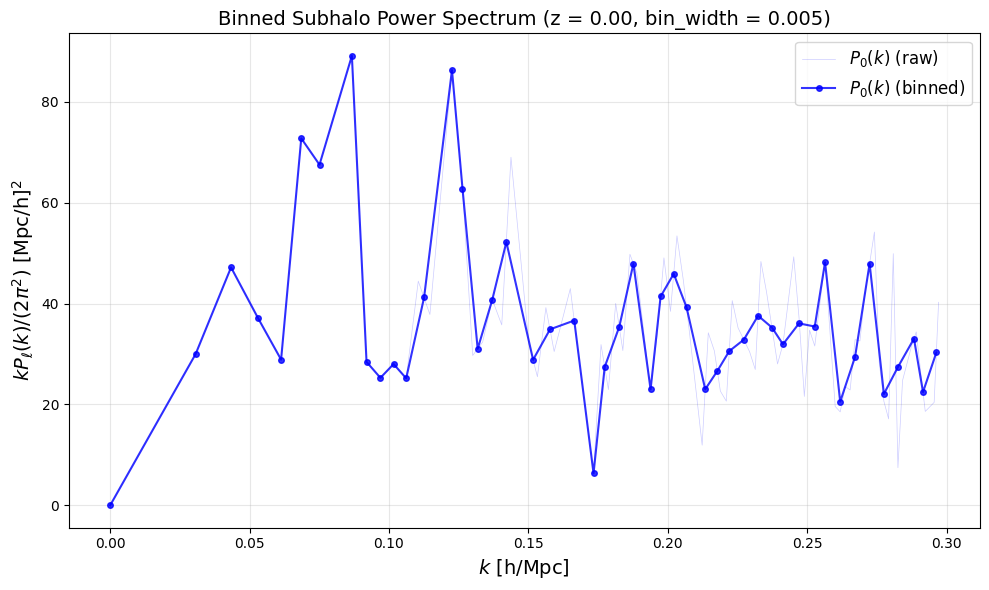

In [7]:
if __name__ == "__main__":
    power = SubhaloPowerSpectrum()
    redshift = 0.0
    data = power.load_data(redshift, mass_cut=1)
    results = power.compute_power_spectrum(redshift, mass_cut=1, ells=(0, 2, 4), use_weights="Mass")

    binned_fig = power.plot_binned_power_spectrum(results,
                                                  bin_width=0.005,
                                                  plot_type='kP',
                                                  multipole=0,
                                                  max_k=0.3,
                                                  show_unbinned=True,
                                                  xscale='linear',
                                                  yscale='linear')


Loading cached redshift-snapshot mapping from /gpfs/nchugh/groupcat_data/pickle_output/redshift_snapshot_mapping.json
Mapping created: {0.82: 55, 0.89: 53, 0.08: 92, 0.26: 80, 0.35: 75, 0.38: 73, 0.76: 57, 0.73: 58, 0.3: 78, 0.48: 68, 0.07: 93, 0.11: 90, 0.18: 85, 0.14: 88, 0.31: 77, 0.6: 63, 0.79: 56, 0.42: 71, 0.03: 96, 0.64: 61, 0.7: 59, 0.68: 60, 0.5: 67, 0.02: 97, 0.36: 74, 0.13: 89, 0.15: 87, 0.52: 66, 0.1: 91, 0.33: 76, 0.92: 52, 0.44: 70, 0.01: 98, 0.24: 81, 0.0: 99, 0.17: 86, 0.58: 64, 0.46: 69, 0.85: 54, 0.95: 51, 0.05: 95, 0.4: 72, 0.55: 65, 0.27: 79, 0.2: 84, 1.0: 50, 0.06: 94, 0.62: 62, 0.23: 82, 0.21: 83}
Loading data from: /gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_99.pkl
Loaded 14485709 subhalos
Actual redshift in data: 0.000
Applied mass cut >= 0.1: 13336701 subhalos remaining (92.1%)
Computing power spectrum with 13336701 subhalos...
Box size: 205001 kpc/h = 205.00 Mpc/h
Mesh size: 400
Multipoles: (0, 2, 4)


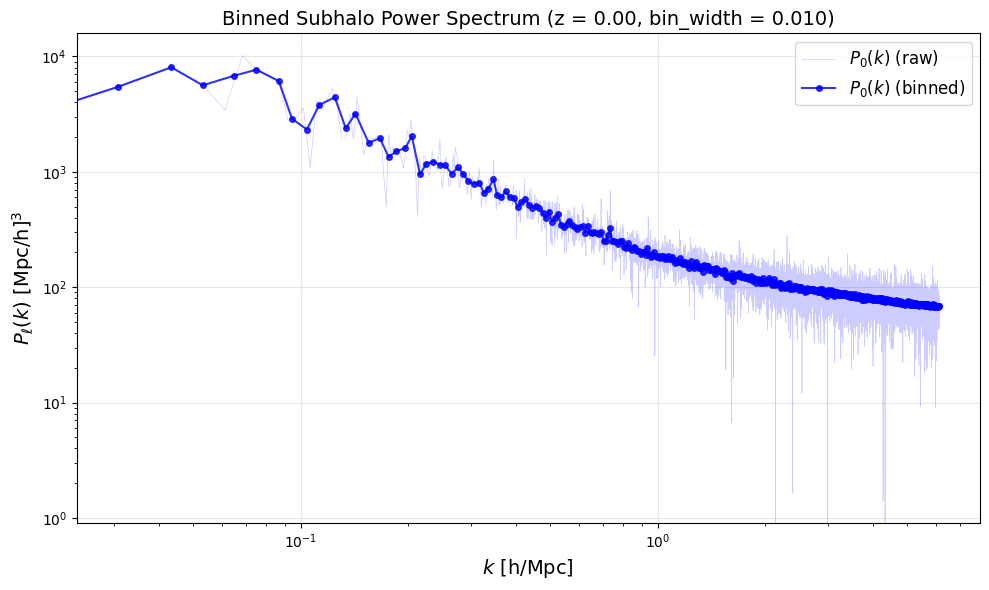

In [8]:
if __name__ == "__main__":
    power = SubhaloPowerSpectrum()
    redshift = 0.0
    data = power.load_data(redshift, mass_cut=0.1)
    results = power.compute_power_spectrum(redshift, mass_cut=0.1, ells=(0, 2, 4), use_weights='SFR')

    binned_fig = power.plot_binned_power_spectrum(results,
                                                  bin_width=0.01,
                                                  plot_type='loglog',
                                                  multipole=0,
                                                  max_k=10,
                                                  show_unbinned=True)

In [1]:
import requests
import numpy as np
import pickle
import h5py
from io import BytesIO

# Your API key from the TNG website
api_key = "a6e92d93311aa4bd2349be55ec31c930"
base_url = "https://www.tng-project.org/api/"

# Headers for authentication
headers = {"api-key": api_key}

def download_dm_data_chunked(simulation="TNG300-1", snapshot=99, chunk_size=1000000):
    """
    Download DM particle data in chunks to manage memory usage
    """
    # Get simulation and snapshot info
    sim_url = f"{base_url}{simulation}/"
    snap_url = f"{sim_url}snapshots/{snapshot}/"
    
    print("Getting snapshot information...")
    r = requests.get(snap_url, headers=headers)
    snap_info = r.json()
    
    # Get the number of DM particles
    num_dm_particles = snap_info['num_particles_type'][1]  # PartType1 = DM
    print(f"Total DM particles: {num_dm_particles:,}")
    
    # Initialize arrays to store data
    all_coordinates = []
    all_masses = []
    
    # Download data in chunks
    num_chunks = (num_dm_particles + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, num_dm_particles)
        
        print(f"Downloading chunk {chunk_idx + 1}/{num_chunks} "
              f"(particles {start_idx:,} to {end_idx:,})")
        
        # Request specific particle range
        params = {
            'dm': 'Coordinates,Masses',  # Only DM coordinates and masses
            'start': start_idx,
            'limit': end_idx - start_idx
        }
        
        chunk_url = f"{snap_url}offsets.hdf5"
        r = requests.get(chunk_url, headers=headers, params=params)
        
        if r.status_code == 200:
            # Load HDF5 data from memory
            with h5py.File(BytesIO(r.content), 'r') as f:
                if 'PartType1' in f:
                    coords = f['PartType1']['Coordinates'][:]
                    masses = f['PartType1']['Masses'][:]
                    
                    all_coordinates.append(coords)
                    all_masses.append(masses)
        else:
            print(f"Error downloading chunk {chunk_idx}: {r.status_code}")
            continue
    
    # Combine all chunks
    print("Combining chunks...")
    coordinates = np.vstack(all_coordinates)
    masses = np.concatenate(all_masses)
    
    return coordinates, masses

def save_dm_data():
    """
    Download DM data and save to pickle file
    """
    try:
        print("Starting TNG300-1 DM data download...")
        coordinates, masses = download_dm_data_chunked()
        
        # Create data dictionary
        dm_data = {
            'coordinates': coordinates,  # Shape: (N, 3) in ckpc/h
            'masses': masses,           # Shape: (N,) in 10^10 Msun/h
            'simulation': 'TNG300-1',
            'snapshot': 99,
            'redshift': 0.0,
            'box_size': 205000.0,       # ckpc/h
            'particle_mass': 0.00398342749867548,  # 10^10 Msun/h
            'num_particles': len(masses)
        }
        
        # Save to pickle file
        output_file = 'tng300_dm_z0.pkl'
        print(f"Saving data to {output_file}...")
        
        with open(output_file, 'wb') as f:
            pickle.dump(dm_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print(f"Successfully saved {len(masses):,} DM particles")
        print(f"Coordinates shape: {coordinates.shape}")
        print(f"File size: {os.path.getsize(output_file) / 1024**3:.2f} GB")
        
        return dm_data
        
    except Exception as e:
        print(f"Error: {e}")
        return None

if __name__ == "__main__":
    # Download and save the data
    data = save_dm_data()
    
    # Basic verification
    if data is not None:
        print("\nData summary:")
        print(f"Number of particles: {data['num_particles']:,}")
        print(f"Coordinate ranges:")
        print(f"  X: {data['coordinates'][:, 0].min():.2f} to {data['coordinates'][:, 0].max():.2f}")
        print(f"  Y: {data['coordinates'][:, 1].min():.2f} to {data['coordinates'][:, 1].max():.2f}")
        print(f"  Z: {data['coordinates'][:, 2].min():.2f} to {data['coordinates'][:, 2].max():.2f}")
        print(f"Mass range: {data['masses'].min():.6f} to {data['masses'].max():.6f}")

Starting TNG300-1 DM data download...
Getting snapshot information...
Error: 'num_particles_type'


In [2]:
import requests
import numpy as np
import pickle
import h5py
import os
from io import BytesIO

# Your API key from the TNG website
api_key = "a6e92d93311aa4bd2349be55ec31c930"
base_url = "https://www.tng-project.org/api/"

# Headers for authentication
headers = {"api-key": api_key}

def debug_snapshot_info(simulation="TNG300-1", snapshot=99):
    """
    Debug function to see what's actually in the snapshot response
    """
    sim_url = f"{base_url}{simulation}/"
    snap_url = f"{sim_url}snapshots/{snapshot}/"
    
    print("Getting snapshot information...")
    r = requests.get(snap_url, headers=headers)
    
    if r.status_code != 200:
        print(f"API request failed with status code: {r.status_code}")
        print(f"Response: {r.text}")
        return None
    
    snap_info = r.json()
    print("Available keys in snapshot info:")
    for key in snap_info.keys():
        print(f"  {key}: {snap_info[key]}")
    
    return snap_info

def download_dm_data_chunked(simulation="TNG300-1", snapshot=99, chunk_size=1000000):
    """
    Download DM particle data in chunks to manage memory usage
    """
    # Get simulation and snapshot info
    sim_url = f"{base_url}{simulation}/"
    snap_url = f"{sim_url}snapshots/{snapshot}/"
    
    print("Getting snapshot information...")
    r = requests.get(snap_url, headers=headers)
    
    if r.status_code != 200:
        print(f"API request failed with status code: {r.status_code}")
        print(f"Response: {r.text}")
        return None, None
    
    snap_info = r.json()
    
    # Debug: print available keys
    print("Available keys in snapshot response:")
    print(list(snap_info.keys()))
    
    # Try different possible keys for particle count
    num_dm_particles = None
    
    if 'num_particles_type' in snap_info:
        num_dm_particles = snap_info['num_particles_type'][1]  # PartType1 = DM
    elif 'num_particles_total' in snap_info:
        # Sometimes it's stored differently
        if isinstance(snap_info['num_particles_total'], list):
            num_dm_particles = snap_info['num_particles_total'][1]
        else:
            print("Need to check particle counts manually")
            return None, None
    elif 'particle_counts' in snap_info:
        num_dm_particles = snap_info['particle_counts'][1]
    else:
        print("Could not find particle count information in snapshot data")
        print("Available keys:", list(snap_info.keys()))
        return None, None
    
    print(f"Total DM particles: {num_dm_particles:,}")
    
    # Initialize arrays to store data
    all_coordinates = []
    all_masses = []
    
    # Download data in chunks
    num_chunks = (num_dm_particles + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, num_dm_particles)
        
        print(f"Downloading chunk {chunk_idx + 1}/{num_chunks} "
              f"(particles {start_idx:,} to {end_idx:,})")
        
        # Request specific particle range
        params = {
            'dm': 'Coordinates,Masses',  # Only DM coordinates and masses
            'start': start_idx,
            'limit': end_idx - start_idx
        }
        
        # Fix the URL - should be the main snapshot URL, not offsets.hdf5
        r = requests.get(snap_url, headers=headers, params=params)
        
        if r.status_code == 200:
            # Load HDF5 data from memory
            try:
                with h5py.File(BytesIO(r.content), 'r') as f:
                    print(f"Available groups in HDF5: {list(f.keys())}")
                    
                    if 'PartType1' in f:
                        coords = f['PartType1']['Coordinates'][:]
                        masses = f['PartType1']['Masses'][:]
                        
                        all_coordinates.append(coords)
                        all_masses.append(masses)
                        print(f"Loaded {len(coords)} particles from chunk {chunk_idx + 1}")
                    else:
                        print(f"PartType1 not found in chunk {chunk_idx}. Available: {list(f.keys())}")
            except Exception as e:
                print(f"Error reading HDF5 data from chunk {chunk_idx}: {e}")
                continue
        else:
            print(f"Error downloading chunk {chunk_idx}: {r.status_code}")
            print(f"Response: {r.text}")
            continue
    
    if not all_coordinates:
        print("No data was successfully downloaded")
        return None, None
    
    # Combine all chunks
    print("Combining chunks...")
    coordinates = np.vstack(all_coordinates)
    masses = np.concatenate(all_masses)
    
    return coordinates, masses

def save_dm_data():
    """
    Download DM data and save to pickle file
    """
    try:
        print("Starting TNG300-1 DM data download...")
        
        # First, let's debug what's in the snapshot info
        snap_info = debug_snapshot_info()
        if snap_info is None:
            return None
        
        coordinates, masses = download_dm_data_chunked()
        
        if coordinates is None or masses is None:
            print("Failed to download data")
            return None
        
        # Create data dictionary
        dm_data = {
            'coordinates': coordinates,  # Shape: (N, 3) in ckpc/h
            'masses': masses,           # Shape: (N,) in 10^10 Msun/h
            'simulation': 'TNG300-1',
            'snapshot': 99,
            'redshift': 0.0,
            'box_size': 205000.0,       # ckpc/h
            'particle_mass': 0.00398342749867548,  # 10^10 Msun/h
            'num_particles': len(masses)
        }
        
        # Save to pickle file
        output_file = 'tng300_dm_z0.pkl'
        print(f"Saving data to {output_file}...")
        
        with open(output_file, 'wb') as f:
            pickle.dump(dm_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print(f"Successfully saved {len(masses):,} DM particles")
        print(f"Coordinates shape: {coordinates.shape}")
        print(f"File size: {os.path.getsize(output_file) / 1024**3:.2f} GB")
        
        return dm_data
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    # Download and save the data
    data = save_dm_data()
    
    # Basic verification
    if data is not None:
        print("\nData summary:")
        print(f"Number of particles: {data['num_particles']:,}")
        print(f"Coordinate ranges:")
        print(f"  X: {data['coordinates'][:, 0].min():.2f} to {data['coordinates'][:, 0].max():.2f}")
        print(f"  Y: {data['coordinates'][:, 1].min():.2f} to {data['coordinates'][:, 1].max():.2f}")
        print(f"  Z: {data['coordinates'][:, 2].min():.2f} to {data['coordinates'][:, 2].max():.2f}")
        print(f"Mass range: {data['masses'].min():.6f} to {data['masses'].max():.6f}")
    else:
        print("Failed to download and save data")

Starting TNG300-1 DM data download...
Getting snapshot information...
Available keys in snapshot info:
  simulation: http://www.tng-project.org/api/TNG300-1/
  number: 99
  redshift: 2.22044604925031e-16
  num_gas: 14454722210
  num_dm: 15625000000
  num_trmc: 15625000000
  num_stars: 711967677
  num_bhs: 701122
  num_groups_fof: 17625892
  num_groups_subfind: 14485709
  num_groups_rockstar: 0
  filesize_snapshot: 4399114089096.0
  filesize_groupcat: 13927642556.0
  filesize_rockstar: 0.0
  url: http://www.tng-project.org/api/TNG300-1/snapshots/99/
  subhalos: http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/
  vis: {'groupcat_sfms': 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/plot.png?xQuant=mstar2_log&yQuant=ssfr&xlim=9.0%2C11.0', 'groupcat_sizemass': 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/plot.png?xQuant=mstar2_log&yQuant=size_stars', 'groupcat_mz_gas': 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/plot.png?xQu

In [4]:
import requests
import numpy as np
import pickle
import h5py
import os
from io import BytesIO

# Your API key from the TNG website
api_key = "a6e92d93311aa4bd2349be55ec31c930"
base_url = "https://www.tng-project.org/api/"

# Headers for authentication
headers = {"api-key": api_key}

def debug_snapshot_info(simulation="TNG300-1", snapshot=99):
    """
    Debug function to see what's actually in the snapshot response
    """
    sim_url = f"{base_url}{simulation}/"
    snap_url = f"{sim_url}snapshots/{snapshot}/"
    
    print("Getting snapshot information...")
    r = requests.get(snap_url, headers=headers)
    
    if r.status_code != 200:
        print(f"API request failed with status code: {r.status_code}")
        print(f"Response: {r.text}")
        return None
    
    snap_info = r.json()
    print("Available keys in snapshot info:")
    for key in snap_info.keys():
        print(f"  {key}: {snap_info[key]}")
    
    return snap_info

def download_dm_data_chunked(simulation="TNG300-1", snapshot=99, chunk_size=1000000):
    """
    Download DM particle data using the TNG API file download approach
    """
    # Get simulation and snapshot info
    sim_url = f"{base_url}{simulation}/"
    snap_url = f"{sim_url}snapshots/{snapshot}/"
    
    print("Getting snapshot information...")
    r = requests.get(snap_url, headers=headers)
    
    if r.status_code != 200:
        print(f"API request failed with status code: {r.status_code}")
        print(f"Response: {r.text}")
        return None, None
    
    snap_info = r.json()
    
    # Get the number of DM particles using the correct field name
    if 'num_dm' in snap_info:
        num_dm_particles = snap_info['num_dm']
    else:
        print("Could not find DM particle count ('num_dm') in snapshot data")
        print("Available keys:", list(snap_info.keys()))
        return None, None
    
    print(f"Total DM particles: {num_dm_particles:,}")
    
    # Get the file download URL
    if 'files' in snap_info and 'snapshot' in snap_info['files']:
        file_url = snap_info['files']['snapshot']
        print(f"File URL: {file_url}")
    else:
        print("Could not find snapshot file URL")
        return None, None
    
    # For very large datasets, we need to download specific particle data
    # The TNG API allows downloading specific particle types and fields
    
    print("Downloading DM particle data...")
    
    # Request only DM particles (PartType1) with Coordinates and Masses
    params = {
        'dm': 'Coordinates,Masses'  # Request only DM coordinates and masses
    }
    
    # Try to download the data
    r = requests.get(file_url, headers=headers, params=params)
    
    if r.status_code == 200:
        print("Download successful, processing HDF5 data...")
        try:
            with h5py.File(BytesIO(r.content), 'r') as f:
                print(f"Available groups in HDF5: {list(f.keys())}")
                
                if 'PartType1' in f:
                    print("Found PartType1 (DM particles)")
                    coords = f['PartType1']['Coordinates'][:]
                    masses = f['PartType1']['Masses'][:]
                    
                    print(f"Loaded {len(coords)} DM particles")
                    return coords, masses
                else:
                    print(f"PartType1 not found. Available particle types: {list(f.keys())}")
                    return None, None
        except Exception as e:
            print(f"Error reading HDF5 data: {e}")
            return None, None
    else:
        print(f"Error downloading data: {r.status_code}")
        print(f"Response: {r.text}")
        
        # If the direct download fails, we might need to use the chunked approach
        # or the file might be too large for direct download
        print("\nDirect download failed. This might be due to file size limitations.")
        print("For TNG300-1, the full snapshot is very large (~4.4TB).")
        print("You may need to:")
        print("1. Download a smaller simulation (e.g., TNG100-1)")
        print("2. Use the TNG data download tools")
        print("3. Request only a subset of particles")
        
        return None, None
    
def download_dm_data_cutout(simulation="TNG100-1", snapshot=99):
    """
    Download DM particle data using the TNG cutout API endpoint.
    """
    snap_url = f"{base_url}{simulation}/snapshots/{snapshot}/"
    
    # Define the API call for a cutout of PartType1 (DM) particles
    cutout_url = f"{snap_url}cutout.hdf5"
    
    # Request only Coordinates and Masses for PartType1 (DM)
    params = {
        'dm': 'Coordinates,Masses'
    }
    
    print(f"Requesting cutout from {cutout_url} ...")
    r = requests.get(cutout_url, headers=headers, params=params)
    
    if r.status_code != 200:
        print(f"Cutout request failed: {r.status_code}")
        print(r.text)
        return None, None
    
    print("Cutout download successful, loading HDF5...")
    
    try:
        with h5py.File(BytesIO(r.content), 'r') as f:
            if 'PartType1' not in f:
                print("PartType1 not found in cutout")
                return None, None
            
            coords = f['PartType1']['Coordinates'][:]
            masses = f['PartType1']['Masses'][:]
            
            print(f"Downloaded {len(masses):,} DM particles")
            return coords, masses
    except Exception as e:
        print(f"Error reading cutout HDF5: {e}")
        return None, None

def save_dm_data(simulation="TNG100-1", snapshot=99):
    """
    Download DM data and save to pickle file
    Default to TNG100-1 which is much smaller than TNG300-1
    """
    try:
        print(f"Starting {simulation} DM data download...")
        
        # First, let's debug what's in the snapshot info
        snap_info = debug_snapshot_info(simulation=simulation, snapshot=snapshot)
        if snap_info is None:
            return None
        
        coordinates, masses = download_dm_data_cutout(simulation=simulation, snapshot=snapshot)
        
        if coordinates is None or masses is None:
            print("Failed to download data")
            return None
        
        # Create data dictionary
        dm_data = {
            'coordinates': coordinates,  # Shape: (N, 3) in ckpc/h
            'masses': masses,           # Shape: (N,) in 10^10 Msun/h
            'simulation': simulation,
            'snapshot': snapshot,
            'redshift': snap_info.get('redshift', 0.0),
            'box_size': 205000.0 if 'TNG300' in simulation else 75000.0,  # ckpc/h
            'num_particles': len(masses)
        }
        
        # Save to pickle file
        output_file = f'{simulation.lower().replace("-", "_")}_dm_z0.pkl'
        print(f"Saving data to {output_file}...")
        
        with open(output_file, 'wb') as f:
            pickle.dump(dm_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print(f"Successfully saved {len(masses):,} DM particles")
        print(f"Coordinates shape: {coordinates.shape}")
        print(f"File size: {os.path.getsize(output_file) / 1024**3:.2f} GB")
        
        return dm_data
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    # Try TNG100-1 first (much smaller than TNG300-1)
    print("Attempting TNG100-1 download first (smaller dataset)...")
    data = save_dm_data(simulation="TNG100-1", snapshot=99)
    
    if data is None:
        print("\nTNG100-1 failed, trying TNG50-1 (even smaller)...")
        data = save_dm_data(simulation="TNG50-1", snapshot=99)
    
    if data is None:
        print("\nSmaller simulations failed. If you specifically need TNG300-1,")
        print("you may need to use the official TNG data download tools or")
        print("download files directly from the TNG website.")
        print("\nTrying TNG300-1 anyway...")
        data = save_dm_data(simulation="TNG300-1", snapshot=99)
    
    # Basic verification
    if data is not None:
        print("\nData summary:")
        print(f"Simulation: {data['simulation']}")
        print(f"Number of particles: {data['num_particles']:,}")
        print(f"Box size: {data['box_size']} ckpc/h")
        print(f"Coordinate ranges:")
        print(f"  X: {data['coordinates'][:, 0].min():.2f} to {data['coordinates'][:, 0].max():.2f}")
        print(f"  Y: {data['coordinates'][:, 1].min():.2f} to {data['coordinates'][:, 1].max():.2f}")
        print(f"  Z: {data['coordinates'][:, 2].min():.2f} to {data['coordinates'][:, 2].max():.2f}")
        print(f"Mass range: {data['masses'].min():.6f} to {data['masses'].max():.6f}")
    else:
        print("Failed to download and save data from any simulation")

Attempting TNG100-1 download first (smaller dataset)...
Starting TNG100-1 DM data download...
Getting snapshot information...
Available keys in snapshot info:
  simulation: http://www.tng-project.org/api/TNG100-1/
  number: 99
  redshift: 2.22044604925031e-16
  num_gas: 5453610043
  num_dm: 6028568000
  num_trmc: 12057136000
  num_stars: 453723346
  num_bhs: 37053
  num_groups_fof: 6291349
  num_groups_subfind: 4371211
  num_groups_rockstar: 0
  filesize_snapshot: 1852107755772.0
  filesize_groupcat: 4446214808.0
  filesize_rockstar: 0.0
  url: http://www.tng-project.org/api/TNG100-1/snapshots/99/
  subhalos: http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/
  vis: {'groupcat_sfms': 'http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/plot.png?xQuant=mstar2_log&yQuant=ssfr&xlim=9.0%2C11.0', 'groupcat_sizemass': 'http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/plot.png?xQuant=mstar2_log&yQuant=size_stars', 'groupcat_mz_gas': 'http://www.tng-project.o